<a href="https://colab.research.google.com/github/Sayem2/abusayem.github.io/blob/master/VGG_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
sp_train_dir = '/content/drive/MyDrive/Parkinson disease Detection Analysis through Machine Learning Approaches/PD-Dataset-1/PD-Dataset/spiral/training'
sp_test_dir = '/content/drive/MyDrive/Parkinson disease Detection Analysis through Machine Learning Approaches/PD-Dataset-1/PD-Dataset/spiral/testing'
wv_train_dir = '/content/drive/MyDrive/Parkinson disease Detection Analysis through Machine Learning Approaches/PD-Dataset-1/PD-Dataset/wave/training'
wv_test_dir = '/content/drive/MyDrive/Parkinson disease Detection Analysis through Machine Learning Approaches/PD-Dataset-1/PD-Dataset/wave/testing'

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, zoom_range=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
sp_train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/Parkinson disease Detection Analysis through Machine Learning Approaches/PD-Dataset-1/PD-Dataset/spiral/training', target_size=(224, 224), batch_size=32, class_mode='categorical')
sp_test_generator = test_datagen.flow_from_directory('/content/drive/MyDrive/Parkinson disease Detection Analysis through Machine Learning Approaches/PD-Dataset-1/PD-Dataset/spiral/testing', target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False)

Found 72 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [ ]:
wv_train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/Parkinson disease Detection Analysis through Machine Learning Approaches/PD-Dataset-1/PD-Dataset/wave/training', target_size=(224, 224), batch_size=32, class_mode='categorical')
wv_test_dir_test_generator = test_datagen.flow_from_directory('/content/drive/MyDrive/Parkinson disease Detection Analysis through Machine Learning Approaches/PD-Dataset-1/PD-Dataset/wave/testing', target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False)

Found 72 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [ ]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(sp_train_generator.num_classes, activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Early Stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Train the model
history = model.fit(sp_train_generator, epochs=50, validation_data=sp_test_generator, callbacks=[early_stopping])


Epoch 1/50
3/3 [==============================] - 127s 41s/step - loss: 0.8511 - accuracy: 0.6250 - val_loss: 1.4224 - val_accuracy: 0.5000
Epoch 2/50
3/3 [==============================] - 124s 55s/step - loss: 0.9451 - accuracy: 0.5972 - val_loss: 0.4637 - val_accuracy: 0.8333
Epoch 3/50
3/3 [==============================] - 91s 29s/step - loss: 0.5957 - accuracy: 0.7083 - val_loss: 0.6468 - val_accuracy: 0.6000
Epoch 4/50
3/3 [==============================] - 102s 46s/step - loss: 0.4038 - accuracy: 0.8194 - val_loss: 0.5429 - val_accuracy: 0.7667
Epoch 5/50
3/3 [==============================] - 83s 28s/step - loss: 0.6341 - accuracy: 0.7361 - val_loss: 0.4398 - val_accuracy: 0.8000
Epoch 6/50
3/3 [==============================] - 104s 38s/step - loss: 0.3813 - accuracy: 0.8333 - val_loss: 0.4851 - val_accuracy: 0.8333
Epoch 7/50
3/3 [==============================] - 84s 38s/step - loss: 0.3857 - accuracy: 0.7917 - val_loss: 0.4128 - val_accuracy: 0.8000
Epoch 8/50
3/3 [=======

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(sp_test_generator)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

1/1 [==============================] - 26s 26s/step - loss: 0.3901 - accuracy: 0.8667
Test accuracy: 86.67%


In [ ]:
# Predict the test set
sp_test_generator.reset()
Y_pred = model.predict(sp_test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = sp_test_generator.classes

1/1 [==============================] - 27s 27s/step


In [ ]:
# Classification Report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=sp_test_generator.class_indices.keys()))


Classification Report
              precision    recall  f1-score   support

     healthy       0.82      0.93      0.87        15
   parkinson       0.92      0.80      0.86        15

    accuracy                           0.87        30
   macro avg       0.87      0.87      0.87        30
weighted avg       0.87      0.87      0.87        30



In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix')
print(cm)

Confusion Matrix
[[14  1]
 [ 3 12]]


In [ ]:
# AUC Curve
fpr = {}
tpr = {}
roc_auc = {}
for i in range(sp_train_generator.num_classes):
    fpr[i], tpr[i], _ = roc_curve(to_categorical(y_true, num_classes=sp_train_generator.num_classes)[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


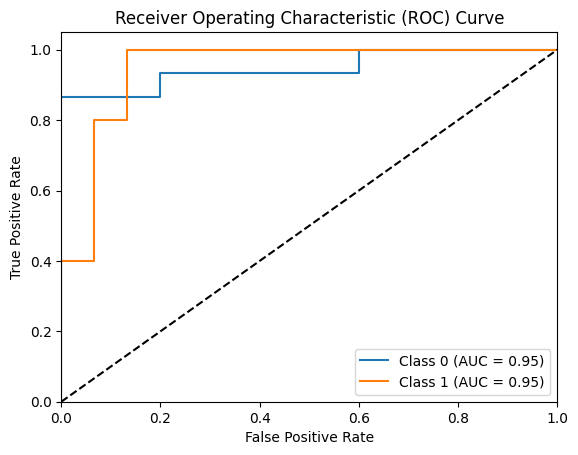

In [ ]:
# Plot AUC Curve
plt.figure()
for i in range(sp_train_generator.num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

*